In [39]:
from IPython.core.display import HTML;css_file = '../../my.css';HTML(open(css_file, "r").read())

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In this practical session we will build a classification model for gene splice site prediction. It is a problem arising in computational gene finding and concerns the recognition of splice sites that mark the boundaries between exons and introns in eukaryotes. Introns are spliced from premature mRNAs after transcription. The vast majority of splice sites are characterized by the presence of specific dimers on the intronic side of the splice site: GT for donor and AG for acceptor sites. Yet, only about 0.1-1% of all GT and AG occurrences in the genome represent true splice sites. 

Load the acceptor site data set in the file "C_elegans_acc_seq-1.csv".

In [41]:
# solution!!
data = pd.read_csv("C_elegans_acc_seq-1.csv")

Investigate the first 5 rows in the DataFrame.

In [42]:
# solution!!
data.head(5)

,target,sequence
0,1,ACTGGGATAATTTGAAACAATAAATTTTTTTTTGAATTGTAGGTGT...
1,1,ATTGATTGAATATTAATTGTTATTTGACGTTATTTTTTAAAGAACT...
2,1,TTTAAACTTCGATTTTTTTCAAATAAAACATATTTTTTTCAGCCAG...
3,1,TAGCCAGATTTTTAGCAGGTTTTAGCAGAAAAACGTTTTCAGACGA...
4,1,TAAACCGCCGATTCTTAAAATTAATTTTTCTTTCTTTTTCAGATGA...


There are only two columns. The column "sequence" contains a DNA sequence with lenght 102. The nucleotides at positions 51 and 52 in the sequence are always "A" and "G" respectively, so these positions are candidate gene acceptor sites. The column "target" indicates the class: 1 for "is acceptor site" and -1 for "is not acceptor site". The goal is to predict the target from the local context sequence of the candidate acceptor site. Let's see how many data points belong to each class:

In [43]:
data['target'].value_counts()

-1    2000
 1     200
Name: target, dtype: int64

First we need to convert the DNA sequence into features. Use the following code to transform each position in the sequence into a categorical feature with 4 values: A, C, G and T.

In [44]:
def convert_sequence(x):
    return list(x['sequence'][30:72])

cols = ["P"+str(i) for i in range(42)]
data_features = pd.DataFrame(list(data.apply(convert_sequence,axis=1)),columns=cols,dtype='category')

Notice how we selected only a part of the sequence to compute the features. What part?

In [45]:
# solution!!
# we selected a local DNA sequence context with 20 nucleotides upstream and 20 nucleotides downstream the candidiate AG.

Investigate the first 5 rows.

In [46]:
# solution!!
data_features.head(5)

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41
0,T,T,T,G,A,A,T,T,G,T,...,G,G,A,G,T,C,G,A,T,G
1,T,A,T,T,T,T,T,T,A,A,...,G,C,G,A,A,A,T,G,G,T
2,T,A,T,T,T,T,T,T,T,C,...,C,G,C,T,A,A,C,G,A,A
3,A,A,A,C,G,T,T,T,T,C,...,C,G,C,C,G,A,T,T,T,A
4,T,T,T,C,T,T,T,T,T,C,...,A,T,T,C,T,C,A,A,T,G


Clearly we can't train a logistic regression model on categorical features. We need to transform these to numerically valued features. The following code transform each nucleotide in an integer.

*Just setting A=0, C=1, G=2 and T=3 doesn't seem like a good idea. If you don't see why not please ask. What we need to do is transform each categorical feature into several features: one feature for each possible value of the categorical feature.* 

In [47]:
data_features_int = data_features.apply(lambda x: x.cat.codes)

Evaluate a logisitc regression model on the data set using 10-fold cross-validation. Use the $cross\_val\_score()$ function to compute the mean accuracy of the CV-scores. 

In [48]:
# solution!!
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

model = LogisticRegression(C=100000)
print np.mean(cross_val_score(model,data_features_int,data.target,cv=10))

0.922727272727


Is this good generalization performance? To invastigate this further let's split the data set into a train (60%) and a test (40%) using the $train\_test\_split()$ function in scikit-learn.

In [49]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features_int, data.target, test_size=0.4, random_state=0)

Train a logistic regression model on the train set.

In [50]:
# solution !!!
model.fit(X_train,y_train)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

To predict the label probabilites of the test set using this model we can use the following code.

In [51]:
predictions = model.predict(X_test)
#predictions

Now we can use the $sklearn.metrics$ to compute the accuracy of these predictions.

In [52]:
from sklearn import metrics

print metrics.accuracy_score(y_test,predictions)

0.921590909091


Let's consider a model that predicts class "-1" for all test points.

In [53]:
predictions_zero = [-1]*len(y_test)

What is the accuracy of this model?

In [37]:
# solution !!
print metrics.accuracy_score(y_test,predictions_zero)

0.903409090909


Clearly in this case accuracy is not a good metric to evaluate the generalization performance. In fact, if there are 0.1% AG dinucleotides in a genome that are true acceptor sites then a model that predicts class "-1" for each AG would have an accuracy of 99.9%. 

For data sets with a large skew in the class distribution it is better to evaluate the performance based on precision and recall. These metrics focus on the positive class in the data set. Given the confusion matrix computed from the predictions we compute precision ($Pr$) and recall ($Re$) as follows:

$$Pr=\frac{TP}{TP+FP},$$

$$Re=\frac{TP}{TP+FN}.$$

These quantities are also related to the ($F_1$) score, which is defined as the harmonic mean of precision and recall:

$$F_1=2\frac{Pr \times Re}{Pr+Re}.$$

We can compute these metrics as follows:

In [57]:
print "Pr=%.2f" % metrics.precision_score(y_test,predictions)
print "Re=%.2f" % metrics.recall_score(y_test,predictions)
print "F1=%.2f" % metrics.f1_score(y_test,predictions)

Pr=0.65
Re=0.41
F1=0.50


Can you explain what these numbers mean? Is this good generalization performance?

Transforming categorical features into ordered integers is not a good idea as the nucleotides don't have an ordering. It is better to transform a categorical feature into one binary feature for each category. We can do this with the following code:

In [59]:
def transform_features(data,column):
    tmp = pd.get_dummies(data[column])
    tmp.columns = [column+ '_' + x for x in tmp]
    return tmp

In [60]:
to_concat = []
for c in data_features.columns.values:
    to_concat.append(transform_features(data_features,c))
data_features_bin = pd.concat(to_concat,axis=1)

Now we created a data set "data_features_bin" that contains features indicating the precense of a specific nucleotide at a specific position in the local context sequences. Investigate the first 5 rows.

In [62]:
# solution!!
data_features_bin.head()

,P0_A,P0_C,P0_G,P0_T,P1_A,P1_C,P1_G,P1_T,P2_A,P2_C,...,P39_G,P39_T,P40_A,P40_C,P40_G,P40_T,P41_A,P41_C,P41_G,P41_T
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Split this data set into a train and test set exactly the same as for the "data_features_int" data set. Then train a logistic regression model on the train set. What is the accuracy, $Pr$, $Re$ and $F_1$ performance on the test set? 

In [65]:
# solution!!!
X_train, X_test, y_train, y_test = train_test_split(data_features_bin, data.target, test_size=0.4, random_state=0)

model.fit(X_train,y_train)

predictions = model.predict(X_test)

print "Acc=%.2f" % metrics.accuracy_score(y_test,predictions)
print "Pr=%.2f" % metrics.precision_score(y_test,predictions)
print "Re=%.2f" % metrics.recall_score(y_test,predictions)
print "F1=%.2f" % metrics.f1_score(y_test,predictions)

Acc=0.94
Pr=0.64
Re=0.74
F1=0.69


So far we have predicted actuall class labels (the list "predictions" contains either "-1" or "1"). We can compute the predicted class probabilities as follows:

In [ ]:
predictions = model.predict_proba(X_test)
predictions

Now "predictions" has two columns that contain the class probabilities for each class. Can you plot the probability distribution of class "1"? 

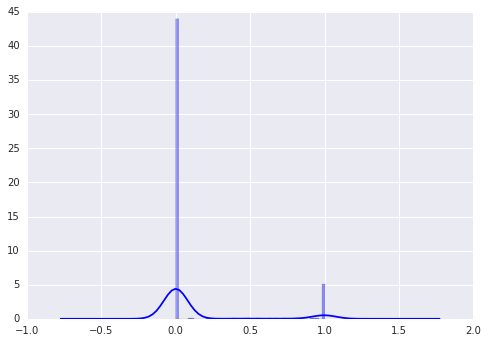

In [68]:
# solution !!
import seaborn as sns

sns.distplot(predictions[:,1], color="b")
plt.show()

Just as with the ROC curve we can now plot a precision-recall curve by applying different decision boundary thresholds on the class distributions. Look-up the $precision\_recall\_curve()$ function in scikit-learn. Can you create such a curve for the test set of the "data_features_bin" set?

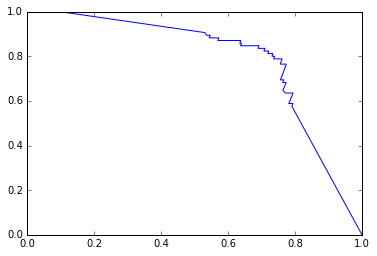

In [16]:
# solution !!
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test,predictions[:,1])

plt.plot(precision,recall)
plt.show()

Can you plot the model paramters of the fitted logisti regression model?

In [20]:
cols = data_features_bin.columns.values

tmp = pd.DataFrame()
tmp['feature'] = cols
tmp['coefficients'] = model.coef_[0]

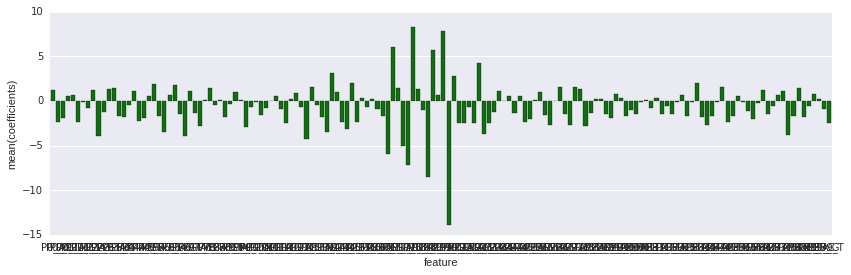

In [21]:
import seaborn as sns

plt.figure(figsize=(14,4))
sns.barplot(x='feature',y='coefficients',data=tmp,color='g')
plt.show()

In [22]:
def map(x):
    if 'A' in x : return 'A'
    if 'C' in x : return 'C'
    if 'G' in x : return 'G'
    return 'T'

tmp["nuc"] = tmp['feature'].apply(map)

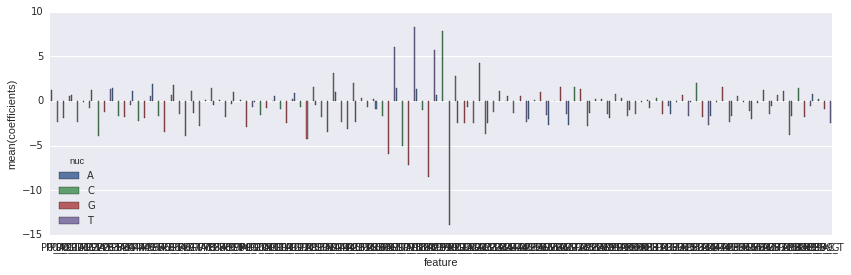

In [23]:
plt.figure(figsize=(14,4))
sns.barplot(x='feature',y='coefficients',data=tmp,hue='nuc')
plt.show()